# Gaussian Regression of Light-Curves

This notebook explores the use of a Gaussian regression to fit CSP light curves. We use a regression implimentation ported from the `avocado` package by [Kyle Boone](https://github.com/kboone).

#### Analysis steps considered by this notebook:

1. <a href='#reading_in_data'>Reading In Data</a>: Read in and format data
1. <a href='#gaussian_regression'>Gaussian Regression</a>: Fit observed light curves using a Gaussian regression
1. <a href='#fit_inspection'>Fit Inspection</a>: Visually inspect regressions of each target
1. <a href='#err_relationship'>Measured and Regressed Error</a>: Examine the relationship between error values reported by CSP and the Gaussian regression
1. <a href='#resampling_errors'>Resampling Errors</a>: Explore the use of a resampling technique for improved error estimation.


In [1]:
import sys
from copy import copy

import numpy as np
import sncosmo
from IPython.display import clear_output
from astropy.table import Column, hstack, vstack
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from sndata.csp import DR3
from tqdm import tqdm

sys.path.insert(0, '../')
from analysis import utils
from analysis import regression

dr3 = DR3()
dr3.download_module_data()
dr3.register_filters(force=True)


## Reading in Data <a id='reading_in_data'></a>

We begin by reading in photometric data from an arbitrarily chosen supernova. To simplify some of our later work, we use the CSP published `t0` value to shift the observed time axis. We also instantiate a SALT2 model.

In [2]:
# Register filters with sncosmo
dr3.download_module_data()
dr3.register_filters(force=True)

# A Salt2.4 model with a Fitzpatrick 99 extinction law
salt2 = sncosmo.Model(sncosmo.get_source('salt2', version='2.4'))


# Gaussian Regression <a id='gaussian_regression'></a>

We use Gaussian regression to fit the light curve in each band. These fits are then compared against a simultaneous fit performed using the Salt2 model.


In [23]:
def plot_regression(data, time, bands, pred_flux, pred_unc):
    """Plot regression results in flux space
    
    Plots data['flux'] and data['fluxerr'] vs time in each band.
    Plots pred_flux and pred_unc vs time in each band.
    
    Args:
        data            (Table): The measured photometric data
        pred_flux (list[float]): Predicted flux from the regression
        pred_unc  (list[float]): Flux uncertainty from the regression
    
    Returns:
        The figure object
        An array of figure axes
    """

    columns = 2
    rows = 5
    fig_shape = (rows, columns)
    fig_size = (3 * rows, 6 * columns)

    fig, axes = plt.subplots(*fig_shape, figsize=fig_size, sharey=True)
    for axis in axes[rows - 1]:
        axis.set_xlabel('Time')

    for axis in axes.flatten()[::2]:
        axis.set_ylabel('Flux')

    plot_data = zip(bands, axes.flatten(), pred_flux, pred_unc)
    for band_name, axis, f, fe in plot_data:
        band_data = data[data['band'] == band_name]
        axis.scatter(band_data['time'], band_data['flux'], label=band_name)
        axis.errorbar(band_data['time'], band_data['flux'],
                      band_data['fluxerr'], linestyle='', label=None)
        
        axis.plot(time, f, linestyle='--', color='black', label='Regression')
        axis.fill_between(
            time,
            f - fe,
            f + fe,
            alpha=.3,
            color='grey',
            label='Regression Error'
        )

        axis.xaxis.set_minor_locator(MultipleLocator(1))
        axis.set_xlim(min(time), max(time))
        axis.legend()

    plt.tight_layout()
    return fig, axes


def subplot_sncosmo_flux(time, bands, fitted_model, axes):
    """Plot the predicted flux of an sncosmo in each band vs time
    
    Args:
        fitted_model (Model): An SNCosmo model fitted to the data
        axes         (array): Use existing axes
    """

    for band, axis in zip(bands, axes.flatten()):
        try:
            band_flux = fitted_model.bandflux(band, time)

        except ValueError as e:
            print(
                f'{fitted_model.source.name} {fitted_model.source.version}: {e}')
            pass

        else:
            axis.plot(time, band_flux, label=f'{fitted_model.source.name}')
            axis.legend()


def subplot_sncosmo_mag(time, bands, fitted_model, axes):
    """Plot the predicted magnitude of an sncosmo in each band vs time
    
    Uses a zero point of 25.
    
    Args:
        fitted_model (Model): An SNCosmo model fitted to the data
        axes         (array): Use existing axes
    """

    for band, axis in zip(bands, axes.flatten()):
        try:
            band_flux = -2.5 * np.log10(fitted_model.bandflux(band, time)) + 25

        except ValueError as e:
            print(f'{fitted_model.source.name} {fitted_model.source.version}: {e}')
            pass

        else:
            axis.plot(time, band_flux, label=f'{fitted_model.source.name}')
            axis.legend()


First, we consider the fit in flux space.

In [34]:
def plot_dr3_flux_regression(obj_id):
    
    data = dr3.get_data_for_id(obj_id)
    
    # Fit a gaussian regression
    gp = regression.fit_gaussian_process(data)
    bands = set(data['band'])
    time = np.arange(min(data['time']) - 1, max(data['time']) + 1)
    gp_flux, gp_unc = regression.predict_light_curve(gp, bands, time)

    # Fit salt2
    salt2.set(z=data.meta['z'])
    salt2.set(t0=utils.get_csp_t0(obj_id))
    fit_result, fitted_model = sncosmo.fit_lc(data, salt2, ['x0', 'x1', 'c'])

    # Plot modeled flux
    fig, axes = plot_regression(data, time, bands, gp_flux, gp_unc)
    subplot_sncosmo_flux(time, bands, fitted_model, axes)
    axes[0, 0].set_ylim(0)


/home/djperrefort/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/fitting.py:158: RuntimeWarning: Dropping following bands from data: csp_dr3_H, csp_dr3_J, csp_dr3_Ydw(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


salt2 2.4: bandpass 'csp_dr3_J' [11050, .., 14050] outside spectral range [2062, .., 9485.2]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2062, .., 9485.2]
salt2 2.4: bandpass 'csp_dr3_Ydw' [9348, .., 11596] outside spectral range [2062, .., 9485.2]


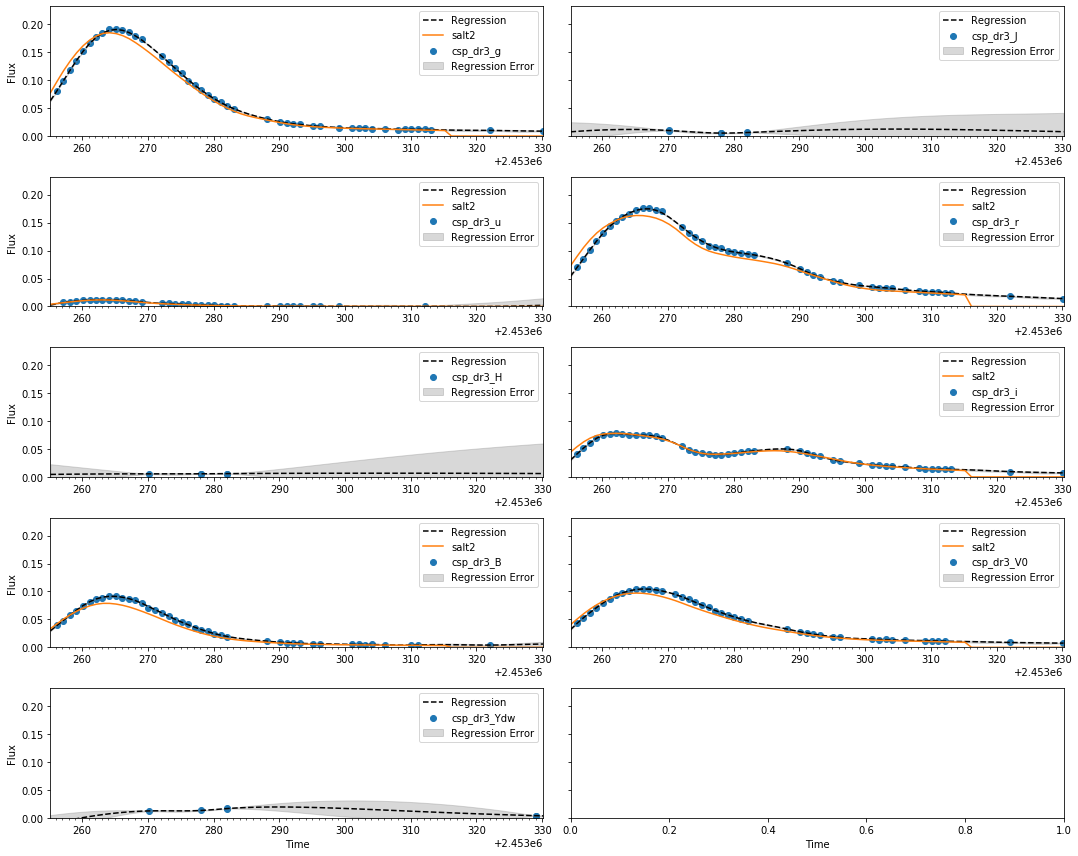

In [35]:
plot_dr3_flux_regression('2004ef')


/home/djperrefort/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/fitting.py:158: RuntimeWarning: Dropping following bands from data: csp_dr3_H, csp_dr3_J, csp_dr3_Y, csp_dr3_Ydw(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_J' [11050, .., 14050] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_Ydw' [9348, .., 11596] outside spectral range [2030.2, .., 9338.92]


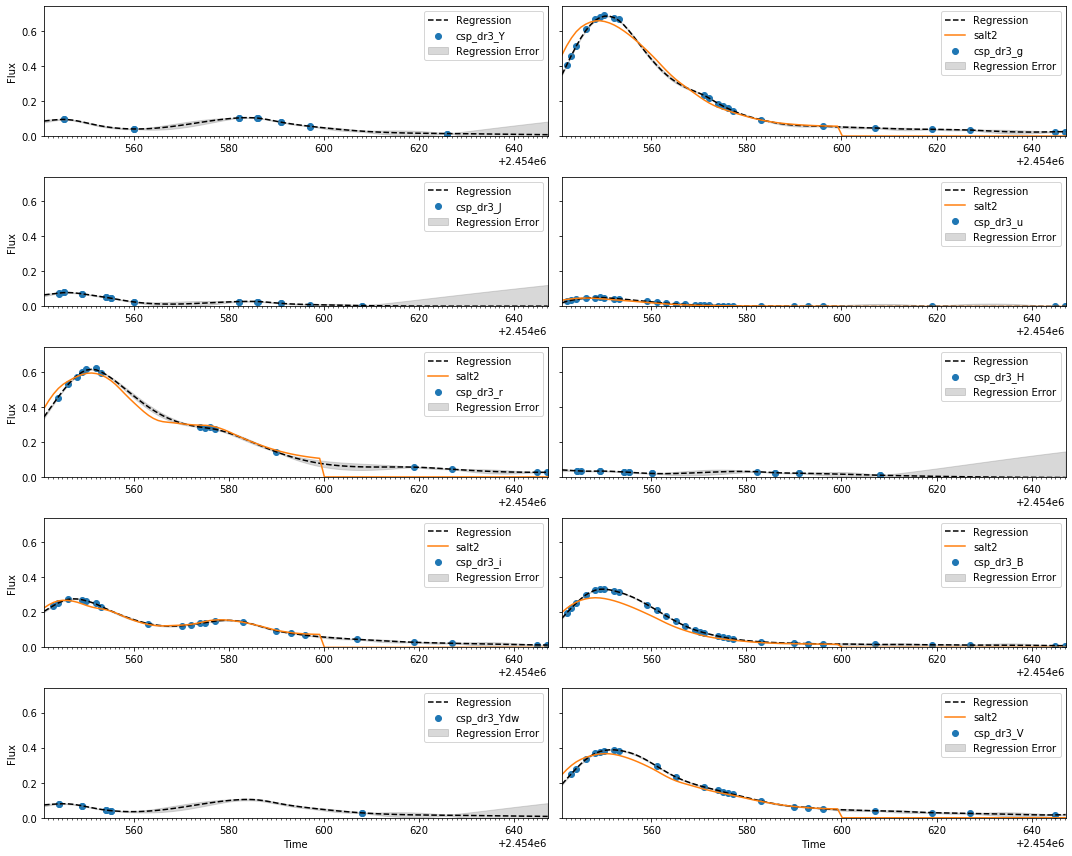

In [36]:
plot_dr3_flux_regression('2008bc')


Next we consider the fit in terms of magnitudes.

In [44]:
def plot_dr3_mag_regression(obj_id):
    data = dr3.get_data_for_id(obj_id)
    data['flux'] = -2.5 * np.log10(data['flux']) + 25
    data['fluxerr'] = (-2.5 * data['fluxerr']) / (data['flux'] * np.log(10))
    
    # Fit a gaussian regression
    gp = regression.fit_gaussian_process(data)
    bands = set(data['band'])
    time = np.arange(min(data['time']) - 1, max(data['time']) + 1)
    gp_flux, gp_unc = regression.predict_light_curve(gp, bands, time)
    
    # Plot fitted magnitudes
    fig, axes = plot_regression(data, time, bands, gp_flux, gp_unc)
    for axis in axes.flatten()[::2]:
        axis.set_ylabel('Magnitude')


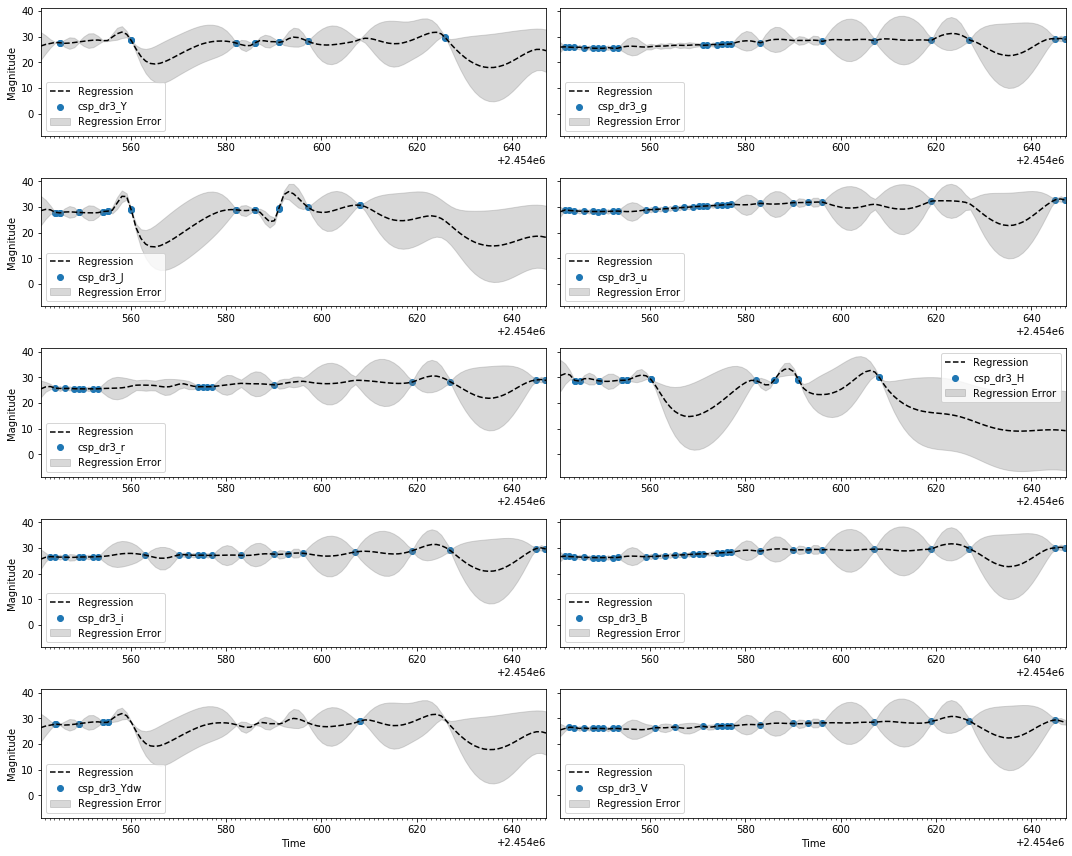

In [47]:
plot_dr3_mag_regression('2008bc')


Although the Gaussian regression performs well within the observed time range, Gaussian regressions are generally bad at extrapolating. For this reason, we choose to limit our use of the above regression when predicting flux values to within the first and last observed data point in each band.

## Measured and Regressed Errors <a id='err_relationship'></a>

We begin by comparing error values published by CSP against those returned by our implementation of a Gaussian regression. We do this for all SNe included in the CSP DR3 data release.



In [78]:
def create_regression_table(data_table):
    """Fit photometric observations with a gaussian regression
    
    This function is a wrapper combining the ``fit_gaussian_process``
    and ``predict_light_curve`` functions from the ``regression`` module.

    Args:
        data (Table): Data table from sndata (format_sncosmo=True)

    Returns:
        An astropy table with measured data and regression results
    """
    
    # Regress light curve and return fitted flux
    bands = set(data_table['band'])
    times = [data_table[data_table['band'] == band]['time'] for band in bands]
    gp = regression.fit_gaussian_process(data_table)
    flux, flux_err = regression.predict_light_curve(gp, bands, times)

    pred_tables = []
    for b, t, f, fe in zip(bands, times, flux, flux_err):
        table_this = Table([t, f, fe], names=['time', 'reg_flux', 'reg_fluxerr'])
        table_this['band'] = Column(b, dtype=object, length=len(table_this))
        pred_tables.append(table_this)
 
    # Use hstack instead of join since there are duplicate band / time combos
    data_table = copy(data_table)
    data_table.sort(['band', 'time'])
    prediction = vstack(pred_tables)
    prediction.sort(['band', 'time'])
    prediction.remove_columns(['band', 'time'])
    out_table = hstack([data_table, prediction])
 
    out_table['obj_id'] = data_table.meta['obj_id']
    out_table['residuals'] = out_table['flux'] - out_table['reg_flux']
    return out_table


def plot_reg_errors(flux, flux_err, reg_err):
    """Plot regressed vs published error values 
    
    Args:
        reg_results (Table): A table from ``create_regression_table``
    """

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    plot_combos = (
        (flux, flux_err),
        (flux, reg_err),
        (flux_err, reg_err)
    )
    
    for (x, y), axis in zip(plot_combos, axes):
        axis.scatter(x, y, label=None)
        
        fit_params = np.polyfit(x, y, 1)
        fit_func = np.poly1d(fit_params)
        axis.plot(
            x, fit_func(x), 
            label=f'{fit_params[0]:0.2}x + {fit_params[1]:0.2}',
            color='black'
        )

        axis.set_xlim(min(x), max(x))
        axis.set_ylim(min(y), max(y))
        axis.legend()

    axes[0].set_xlabel(f'Published Flux')
    axes[0].set_ylabel(f'Published Error')
    axes[1].set_xlabel(f'Published Flux')
    axes[1].set_ylabel(f'Regression Error')
    axes[2].set_xlabel(f'Published Error')
    axes[2].set_ylabel(f'Regression Error')
    
    axes[2].plot([-1, 1], [-1, 1], color='black', linestyle='--')
    
    plt.tight_layout()
    plt.show()



In [81]:
all_targets = vstack(
    [create_regression_table(data_table) for data_table in dr3.iter_data(verbose=True)],
    metadata_conflicts='silent'
)


  9%|▉         | 12/134 [00:02<00:26,  4.61it/s]../analysis/regression/_lc_regression.py:107: UserWarning: GP fit failed! Using guessed GP parameters. 
  warn("GP fit failed! Using guessed GP parameters. ")
100%|██████████| 134/134 [00:13<00:00,  9.58it/s]


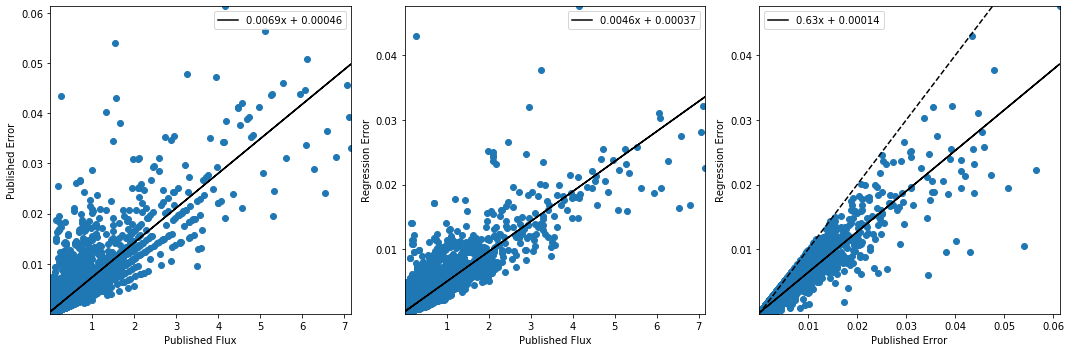

In [82]:
plot_reg_errors(all_targets['flux'], all_targets['fluxerr'], all_targets['reg_fluxerr'])


We note that the regression errors are about 60% the size of the published errors and are always smaller. A simple way to account for this is to divide the regression error by a constant (.6). A more complicate approach is to apply a type of sampling to achieve more realistic error values from the regression.

## Resampling Errors <a id='resampling_errors'></a>

#### Important: This section was exploritory and we ultimatly decided the approach was a "bad" idea.

We explore the usage of resampling techniques and their effects on the regression error values. The resampling algorithm starts by performing a Gaussian regression on a given target and calculating the residuals. The residuals are randomly added to the original measured flux. The process is then repeated over several iterations before the standard deviation is determined for each predicted flux value.

The first step of our algorithm is already completed above. Next we define functions to implement the resampling part of the algorithm. We do this twice and consider the result when we reshuffle the residuals both across and within each bandpass.


In [53]:
def shuffle_residuals(reg_results, respect_bands=True):
    """Return an array of residuals that have been suffled
    
    By default residuals are shuffled within each bandpass.
    
    Args:
        reg_results  (Table): A table from ``create_regression_table``
        respect_bands (bool): Only reshuffle residuals in their respective bands
    """

    if not respect_bands:
        return np.random.permutation(reg_results['residuals'])

    shuffled_resids = np.empty(len(reg_results))
    for band in set(reg_results['band']):
        indices = reg_results['band'] == band
        band_resids = reg_results['residuals'][indices]
        shuffled_resids[indices] = np.random.permutation(band_resids)

    return shuffled_resids


def resample_regression(reg_results, respect_bands, num_iters):
    """Iteritively perform regressions while shiffling residuals
    
    Args:
        reg_results  (Table): An initial regression from ``create_regression_table``
        respect_bands (bool): Only reshuffle residuals in their respective bands
        num_iters      (int): The number of iterations to perform
        
    Returns:
        An array of the flux values predicted at each iteration
        An array of standard deviations in the flux values at each iteration
    """

    regressed_flux = []
    std_dev = []
    for _ in tqdm(range(num_iters)):
        # Create a new table with the measured flux values + residuals
        shuffled_resids = shuffle_residuals(reg_results, respect_bands)
        new_table = reg_results['time', 'band']
        new_table['flux'] = reg_results['flux'] + shuffled_resids
        new_table['fluxerr'] = reg_results['fluxerr'] + shuffled_resids

        # Calculate the standard deviation in regressed flux at each iteration
        new_regression = create_regression_table(new_table)
        regressed_flux.append(list(new_regression['reg_flux']))
        std_dev.append(np.std(regressed_flux, axis=0))

    return np.array(regressed_flux), np.array(std_dev).T


In [64]:
# Perform an initial regression
demo_data = dr3.get_data_for_id('2004ef')
regression_data = create_regression_table(demo_data)

# Run resampling
print('Resampling across bands:')
resampled_flux, std_deviation = resample_regression(regression_data, False, 500)

print('Resampling within bands:')
resampled_flux_band, std_deviation_band = resample_regression(regression_data, True, 500)


  0%|          | 1/500 [00:00<00:55,  9.05it/s]

Resampling across bands:


  1%|          | 3/500 [00:00<00:54,  9.17it/s]../analysis/regression/_lc_regression.py:107: UserWarning: GP fit failed! Using guessed GP parameters. 
  warn("GP fit failed! Using guessed GP parameters. ")
  0%|          | 1/500 [00:00<00:54,  9.19it/s]

Resampling within bands:


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


It is worth checking how the standard deviation converges with the number of iterations.

In [55]:
def plot_resample_convergance(reg_results, std_dev):
    """Plot the standard deviation per band per iteration
    
    Args:
        reg_results (Table): An initial regression from ``create_regression_table``
        std_dev     (array): Standard deviations per iteration per data point
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """

    # Auto determine figure size
    bands = set(reg_results['band'])
    columns = 2
    rows = int(np.ceil(len(bands) / columns))
    fig, axes = plt.subplots(rows, columns, figsize=(4 * rows, 8 * columns))

    # Plot results per band
    for band, axis in zip(bands, axes.flatten()):
        axis.set_title(band)
        band_indices = np.where(reg_results['band'] == band)[0]
        for i in band_indices:
            axis.plot(std_dev[i])
            axis.set_xlim(0, len(std_dev[i]))

    axes[-1, 0].set_xlabel('Number of iterations', fontsize=14)
    axes[-1, 1].set_xlabel('Number of iterations', fontsize=14)
    for axis in axes[:, 0]:
        axis.set_ylabel('Standard Deviattion', fontsize=14)

    plt.tight_layout()
    return fig, axes


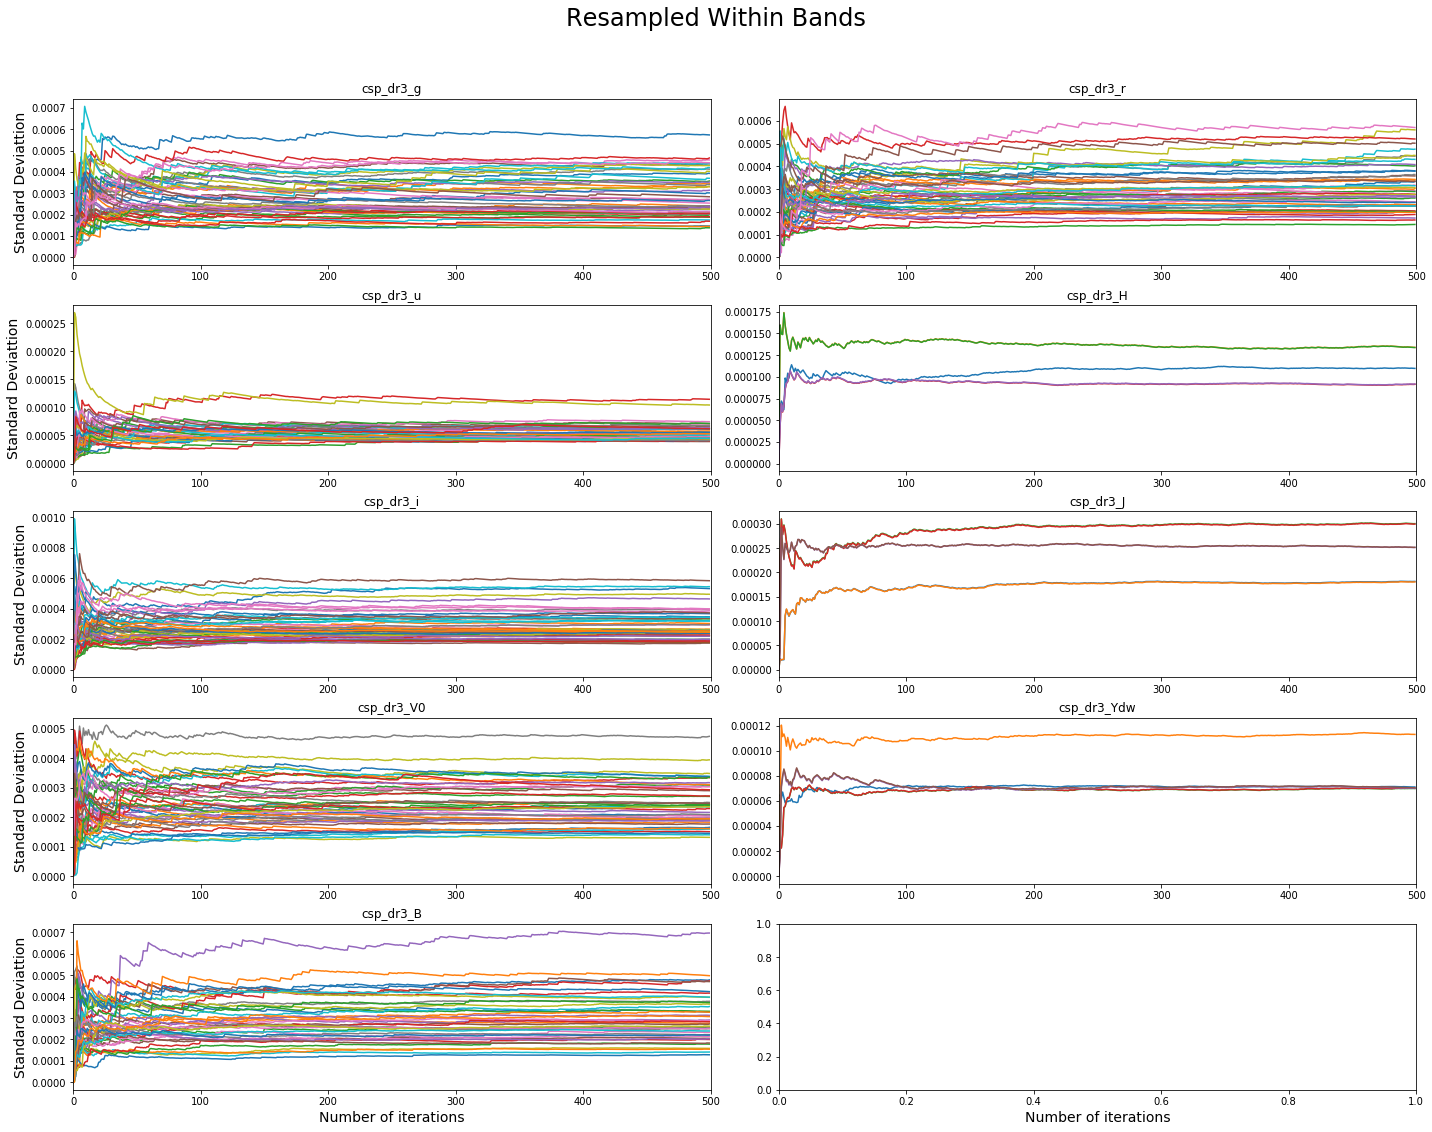

In [65]:
fig, axes = plot_resample_convergance(regression_data, std_deviation_band)
fig.suptitle('Resampled Within Bands', fontsize=24)
plt.subplots_adjust(top=.9)


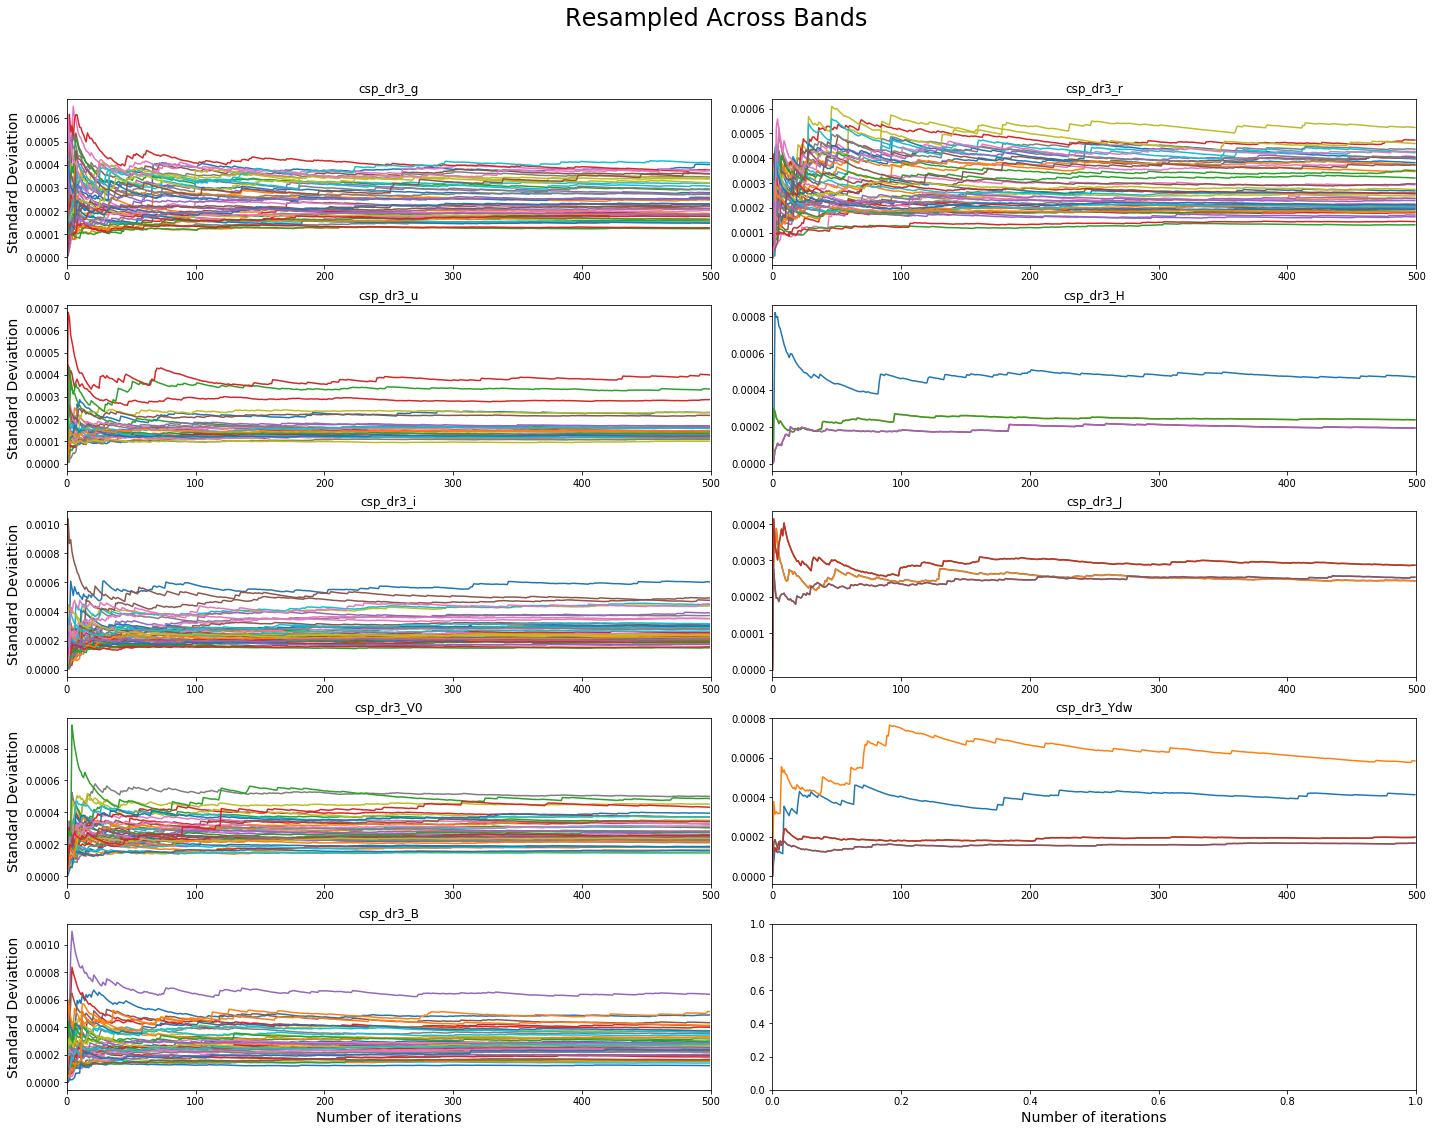

In [66]:
fig, axes = plot_resample_convergance(regression_data, std_deviation)
fig.suptitle('Resampled Across Bands', fontsize=24)
plt.subplots_adjust(top=.9)


We see from the above that for the chosen target the standard deviation converges fairly quickly. The standard deviation takes slightly longer to converge when resampling across bands, but that is to be expected. To characterize the converged standard deviation, we take the average over the final 100 iterations. We then compare that average against the published and single regression error values.

In [67]:
def plot_resampled_errors(reg_results, std_dev):
    """Plot resampled error vs published and single regression errors
    
    Args:
        reg_results (Table): An initial regression from ``create_regression_table``
        std_dev     (array): Standard deviations per iteration per data point
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """

    average_std = np.average(std_dev[:, -100:], axis=1)
    plot_combos = (
        (reg_results['fluxerr'], reg_results['reg_fluxerr']),
        (reg_results['fluxerr'], average_std),
        (reg_results['reg_fluxerr'], average_std)
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for (x, y), axis in zip(plot_combos, axes):
        for band in set(reg_results['band']):
            indices = np.where(reg_results['band'] == band)[0]
            axis.scatter(x[indices], y[indices], label=band.split('_')[-1])

        axis.plot([-1, 1], [-1, 1], label=None, linestyle='--', color='black')
        axis.set_xlim(0, max(max(x), max(y)))
        axis.set_ylim(0, max(max(x), max(y)))
        axis.legend()

    axes[0].set_xlabel(f'Published Error')
    axes[0].set_ylabel(f'Single Regression Error')
    axes[1].set_xlabel(f'Published Error')
    axes[1].set_ylabel(f'Resampled Error')
    axes[2].set_xlabel(f'Single Regression Error')
    axes[2].set_ylabel(f'Resampled Error')

    return fig, axes


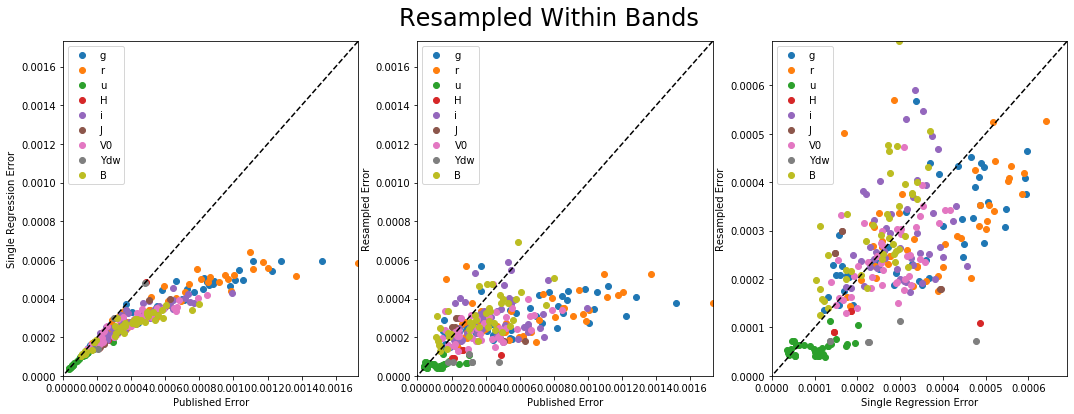

In [68]:
fig, axes = plot_resampled_errors(regression_data, std_deviation_band)
fig.suptitle('Resampled Within Bands', fontsize=24)
plt.subplots_adjust(top=.9)
plt.show()


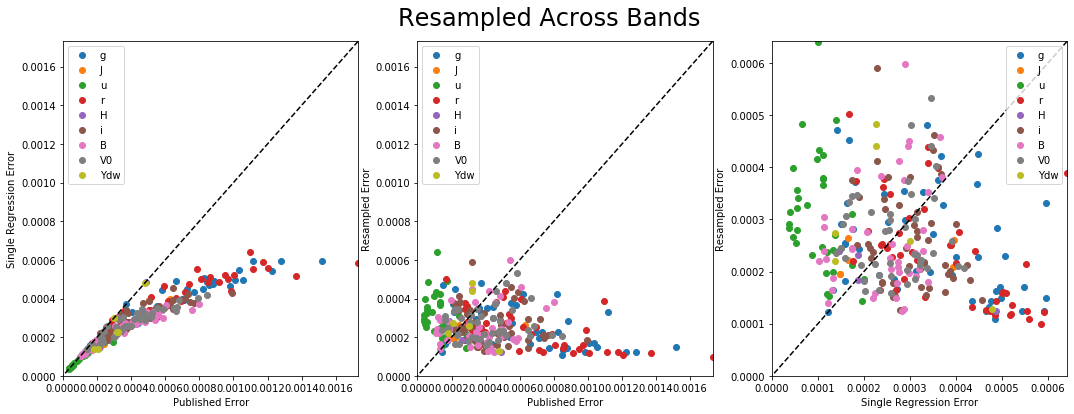

In [98]:
fig, axes = plot_resampled_errors(regression_data, std_deviation)
fig.suptitle('Resampled Across Bands', fontsize=24)
plt.subplots_adjust(top=.9)


## Mapping Regression Error Values in Functional Form

(0, 0.0016)

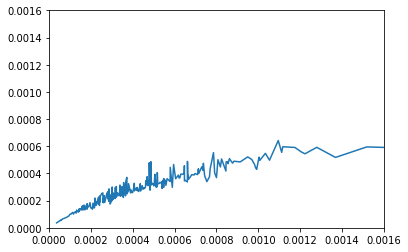

In [136]:
regression_data.sort('fluxerr')
plt.plot(regression_data['fluxerr'], regression_data['reg_fluxerr'])
plt.xlim(0, 0.0016)
plt.ylim(0, 0.0016)

In [139]:
def sqrt(x, a, b):
    return a * np.sqrt(x) + b

def neg_exp(x, a, b, c):
    return - a * np.exp(-b * x) + c

from scipy.optimize import curve_fit


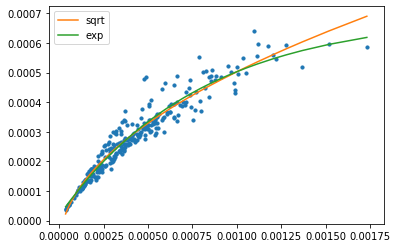

In [154]:
xdata, ydata = regression_data['fluxerr'], regression_data['reg_fluxerr']
sqrt_opt, sqrt_cov = curve_fit(sqrt, xdata, ydata)
exp_opt, exp_cov = curve_fit(neg_exp, xdata, ydata)

plt.plot(xdata, sqrt(xdata, *sqrt_opt),label='sqrt', color='C1')
plt.plot(xdata, neg_exp(xdata, *exp_opt), label='exp', color='C2')
plt.scatter(xdata, ydata, s=10)
plt.legend()


In [147]:
def scale_with_exponential(x, a, b, c):
    return np.log(a / (c - x)) / b


(0, 0.00173279898596022)

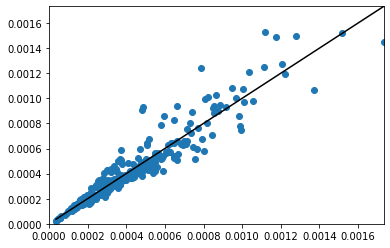

In [157]:
plt.plot(xdata, xdata, color='k')
plt.scatter(xdata, scale_with_exponential(ydata, *exp_opt))
plt.xlim(0, max(xdata))
plt.ylim(0, max(xdata))
